5.245942405484991e-17
Date
2021-11-11    0.201683
2021-11-12    0.043333
2021-11-15    0.141161
2021-11-16    0.136279
2021-11-17   -0.156194
                ...   
2026-01-21   -0.000236
2026-01-22   -0.016457
2026-01-23   -0.021012
2026-01-26   -0.019652
2026-01-27   -0.035910
Name: Close, Length: 1055, dtype: float64
-2.36777422313422e-19
period： 2025-07-27 → 2026-01-27

===== Analyzing portfolio： TSLA 和 NIO =====
ρ(TSLA, NIO) = 0.2183
alpha(TSLA on NIO) = 68.3839


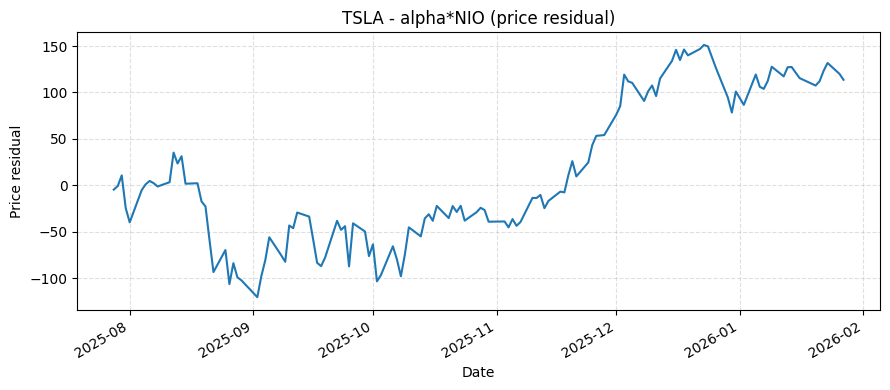

Minimum variance portfolio weights：
  TSLA weight = 0.7277354122453356
  NIO weight = 0.27226458775466444

===== Analyzing portfolio： RIVN 和 NIO =====
ρ(RIVN, NIO) = 0.1004
alpha(RIVN on NIO) = 2.4891


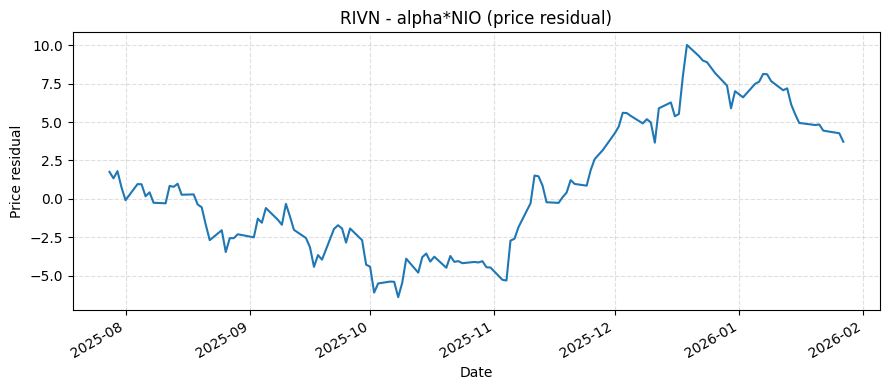

Minimum variance portfolio weights：
  RIVN weight = 0.5065900910491391
  NIO weight = 0.4934099089508609

===== Analyzing portfolio： TSLA 和 RIVN =====
ρ(TSLA, RIVN) = 0.3736
alpha(TSLA on RIVN) = 26.6204


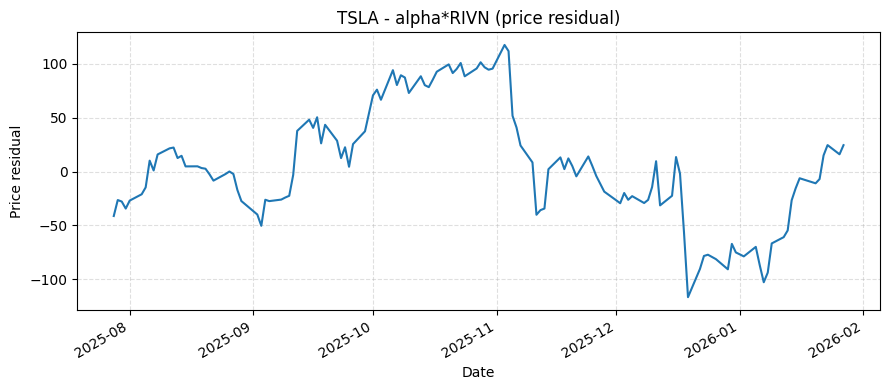

Minimum variance portfolio weights：
  TSLA weight = 0.7709982220501456
  RIVN weight = 0.22900177794985443


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tsla = pd.read_csv(
    "https://stooq.com/q/d/l/?s=tsla.us&i=d",
    parse_dates=["Date"]
).set_index("Date").sort_index()

rivn = pd.read_csv(
    "https://stooq.com/q/d/l/?s=rivn.us&i=d",
    parse_dates=["Date"]
).set_index("Date").sort_index()

nio = pd.read_csv(
    "https://stooq.com/q/d/l/?s=nio.us&i=d", 
    parse_dates=["Date"]
).set_index("Date").sort_index()
spy = pd.read_csv(
    "https://stooq.com/q/d/l/?s=spy.us&i=d",
    parse_dates=["Date"]
).set_index("Date").sort_index()
r_m = np.log(spy["Close"]).diff().dropna()
r_tsla= np.log(tsla["Close"]).diff().dropna()
r_rivn=np.log(rivn["Close"]).diff().dropna()
tmp = pd.concat([r_tsla, r_rivn, r_m], axis=1).dropna()
r_tsla = tmp.iloc[:, 0]
r_rivn = tmp.iloc[:, 1]
r_m    = tmp.iloc[:, 2]
beta_tsla = np.cov(r_tsla, r_m, ddof=1)[0,1] / np.var(r_m, ddof=1)
beta_rivn = np.cov(r_rivn, r_m, ddof=1)[0,1] / np.var(r_m, ddof=1)

alpha_tsla = r_tsla.mean() - beta_tsla * r_m.mean()
alpha_rivn = r_rivn.mean() - beta_rivn * r_m.mean()
eps_tsla = r_tsla - alpha_tsla - beta_tsla * r_m
eps_rivn = r_rivn - alpha_rivn - beta_rivn * r_m

print(eps_tsla.corr(r_m))
print(eps_rivn)
print(eps_tsla.mean())



df = pd.concat(
    [
        tsla["Close"].rename("TSLA"),
        rivn["Close"].rename("RIVN"),
        nio["Close"].rename("NIO"),
    ],
    axis=1
).dropna()


end_date = df.index.max()
start_6m = end_date - pd.DateOffset(months=6)
window = df.loc[start_6m:end_date]
print("period：", start_6m.date(), "→", end_date.date())

def analyze_pair(price_df, col_a, col_b):
    print("\n===== Analyzing portfolio：", col_a, "和", col_b, "=====")
    A = price_df[col_a]
    B = price_df[col_b]

   
    log_rets = np.log(price_df[[col_a, col_b]]).diff().dropna()
    x = log_rets[col_a].values
    y = log_rets[col_b].values


    xm = x - x.mean()
    ym = y - y.mean()
    cov_xy = (xm @ ym) / (len(x) - 1)
    sx = ((xm**2).sum() / (len(x) - 1)) ** 0.5
    sy = ((ym**2).sum() / (len(y) - 1)) ** 0.5
    rho = cov_xy / (sx * sy)
    print(f"ρ({col_a}, {col_b}) = {rho:.4f}")

    alpha = (A * B).sum() / (B**2).sum()
    V = A - alpha * B
    print(f"alpha({col_a} on {col_b}) = {alpha:.4f}")


    plt.figure(figsize=(9, 4))
    V.plot()
    plt.title(f"{col_a} - alpha*{col_b} (price residual)")
    plt.xlabel("Date")
    plt.ylabel("Price residual")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


    cov_mat = log_rets.cov().values
    var_a = cov_mat[0, 0]
    var_b = cov_mat[1, 1]
    cov_ab = cov_mat[0, 1]

    w_a = (var_b - cov_ab) / (var_a + var_b - 2 * cov_ab)
    w_b = 1 - w_a

    print("Minimum variance portfolio weights：")
    print(f"  {col_a} weight = {w_a}")
    print(f"  {col_b} weight = {w_b}")

    return {
        "rho": rho,
        "alpha": alpha,
        "w_a": w_a,
        "w_b": w_b,
    }

result_tsla_nio = analyze_pair(window[["TSLA", "NIO"]], "TSLA", "NIO")

result_rivn_nio = analyze_pair(window[["RIVN", "NIO"]], "RIVN", "NIO")

result_tsla_rivn = analyze_pair(window[["TSLA", "RIVN"]], "TSLA", "RIVN")


